In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from tensorflow import data as tf_data
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt

from sklearn.model_selection import train_test_split

from preprocess_common import *

from record_save_load import *

2025-03-23 22:08:20.789665: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define the HyperParameters

We fix some hyperparmeters like IMG_SIZE at a per model level, since each model excels at certain image sizes [1](https://link.springer.com/chapter/10.1007/978-3-030-86340-1_11). 

We also fix batch size and other parameters due to memory and compute constraints as well. We fix the seed for reproducibility

In [2]:
class_names=['Human', 'AI']
AUTO = tf_data.AUTOTUNE # Parallelize data loading
#Hyperparameters
BATCH_SIZE = 16
BUFFER_SIZE = 1024
IMG_SIZE = (224,224)

SEED = 44

## Load the CSV's 

In [3]:
class_names=['Human', 'AI']

res_train_ds = load_tfrecord("records/resnet_train.tfrecord", BATCH_SIZE, "resnet").repeat()
res_val_ds = load_tfrecord("records/resnet_val.tfrecord", BATCH_SIZE, "resnet")

2025-03-21 11:52:41.918032: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:906] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.3/numa_node
Your kernel may have been built without NUMA support.
2025-03-21 11:52:43.754363: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:906] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.3/numa_node
Your kernel may have been built without NUMA support.
2025-03-21 11:52:43.754419: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:906] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.3/numa_node
Your kernel may have been built without NUMA support.
2025-03-21 11:52:43.756838: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:906] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.3/numa_node
Your kernel may have been built without NUMA support.
2025-03-21 11:52:43.756969: I external/local_xla/xla/stream_executor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

(224, 224, 3)


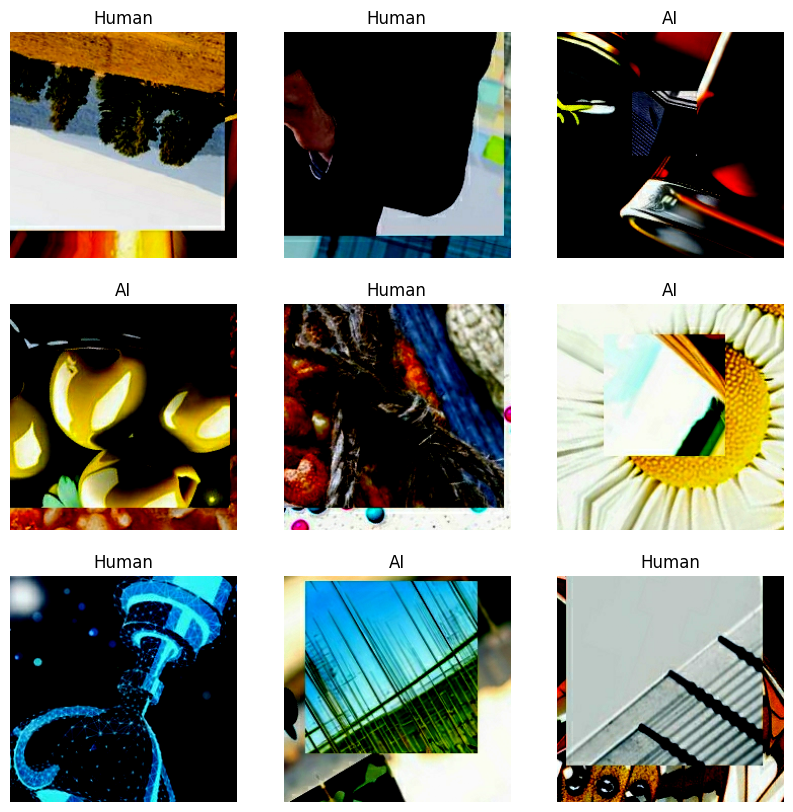

In [4]:
image_batch, label_batch = next(iter(res_train_ds))
print(image_batch[0].shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


#Hyperparameters
NUM_CLASSES = 2  
LEARNING_RATE = 0.0001
MOMENTUM = 0.9
BATCH_SIZE = 32
EPOCHS = 16

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze layers
base_model.trainable = False

# Stochastic Weight Averaging (SWA) 
class SWA(tf.keras.callbacks.Callback):
    def __init__(self, swa_epoch):
        super(SWA, self).__init__()
        self.swa_epoch = swa_epoch 

    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
        elif epoch > self.swa_epoch:
            for i, layer in enumerate(self.model.layers):
                self.swa_weights[i] = (self.swa_weights[i] * (epoch - self.swa_epoch) + self.model.get_weights()[i]) / (epoch - self.swa_epoch + 1)

    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)



Trial 14 Complete [00h 18m 28s]
val_f1_score: 0.7923722267150879

Best val_f1_score So Far: 0.7993080615997314
Total elapsed time: 02h 09m 19s


ResNet-50 Model

In [106]:
# ResNet-50 Model
def build_resnet50(hparams):

    # Add custom layers
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    
    units = hparams.Int('units', min_value=128, max_value=256, step=64)
    
    x = layers.Dense(units, activation='relu')(x)
    
    dropout_rate = hparams.Float('dropout_rate', 0.2, 0.4, step=0.1)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x) 
    
    model = models.Model(inputs, outputs)
    
    
    learning_rate = hparams.Float('learning_rate', 1e-4, 1e-3, sampling='log')
    momentum = hparams.Float('momentum', 0.9, 0.99, sampling='log')
    
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, clipvalue=1.0)  # Gradient Clipping
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),  # Use Focal Loss
        metrics=[keras.metrics.AUC(multi_label=True),
                keras.metrics.F1Score("macro")]
    )

    return model

# Define the Hyperband tuner
tuner = kt.Hyperband(
    build_resnet50,
    objective=kt.Objective("val_f1_score", direction="max"),  
    max_epochs=EPOCHS,
    factor=6,  
    directory="hyperband_tuning",
    project_name="resnet_tuning"
)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=3)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs/resnet_tuning")

# Run the hyperparameter search
tuner.search(
    res_train_ds,
    validation_data=res_val_ds,
    epochs=EPOCHS,
    steps_per_epoch=1999,
    callbacks=[early_stopping, tensorboard_callback]
)




## Visualizing Hyperband 

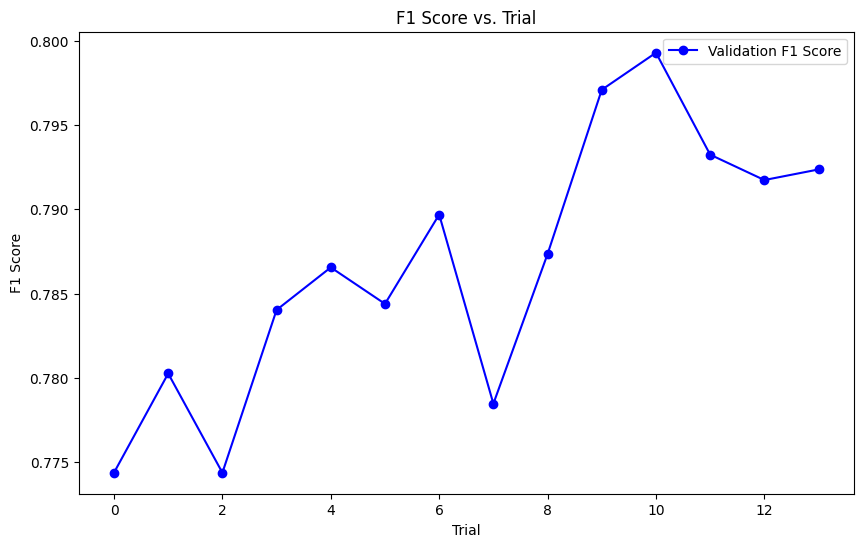

In [18]:
import matplotlib.pyplot as plt

# Extract trials from tuner
trials = tuner.oracle.trials.values()

# Collect trial IDs and validation F1 scores
trial_ids = []
val_f1_scores = []

for i, trial in enumerate(trials):
    if "val_f1_score" in trial.metrics.metrics:
        f1_history = trial.metrics.metrics["val_f1_score"].get_history()
        if f1_history:  # Ensure it's not empty
            val_f1_scores.append(f1_history[-1].value)  # Last recorded value
            trial_ids.append(i)  # Use index as trial ID

# Plot the results
plt.figure(figsize=(10, 6))
plt.title("F1 Score vs. Trial")
plt.xlabel("Trial")
plt.ylabel("F1 Score")
plt.plot(trial_ids, val_f1_scores, marker="o", linestyle="-", label="Validation F1 Score", color="blue")
plt.legend()
plt.show()


## Fit the best Model with max epochs 

In [5]:
EPOCHS = 32

In [ ]:

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs/resnet_tuning_best")
save_model = keras.callbacks.ModelCheckpoint("models/resnet_best.h5", save_best_only=True)

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(
    res_train_ds,
    validation_data=res_val_ds,
    epochs=EPOCHS,
    steps_per_epoch=1999,
    callbacks=[early_stopping, tensorboard_callback, save_model]
)

Epoch 1/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 99s 48ms/step - auc_4: 0.7490 - f1_score: 0.6860 - loss: 0.6144 - val_auc_4: 0.8611 - val_f1_score: 0.7775 - val_loss: 0.4694
Epoch 2/32
   3/1999 ━━━━━━━━━━━━━━━━━━━━ 1:11 36ms/step - auc_4: 0.8984 - f1_score: 0.7844 - loss: 0.4548

/home/david/.pyenv/versions/3.12.9/envs/3.12stad68/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 93s 47ms/step - auc_4: 0.7976 - f1_score: 0.7263 - loss: 0.5465 - val_auc_4: 0.8684 - val_f1_score: 0.7855 - val_loss: 0.4591
Epoch 3/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 90s 45ms/step - auc_4: 0.8097 - f1_score: 0.7289 - loss: 0.5317 - val_auc_4: 0.8699 - val_f1_score: 0.7876 - val_loss: 0.4550
Epoch 4/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 90s 45ms/step - auc_4: 0.8128 - f1_score: 0.7363 - loss: 0.5288 - val_auc_4: 0.8742 - val_f1_score: 0.7903 - val_loss: 0.4509
Epoch 5/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 89s 45ms/step - auc_4: 0.8206 - f1_score: 0.7431 - loss: 0.5181 - val_auc_4: 0.8729 - val_f1_score: 0.7912 - val_loss: 0.4507
Epoch 6/32
   5/1999 ━━━━━━━━━━━━━━━━━━━━ 1:04 32ms/step - auc_4: 0.9034 - f1_score: 0.8264 - loss: 0.4164

2025-03-21 14:16:40.697035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7842813308098566857
2025-03-21 14:16:40.697087: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18298526860390909505


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 90s 45ms/step - auc_4: 0.8202 - f1_score: 0.7449 - loss: 0.5189 - val_auc_4: 0.8762 - val_f1_score: 0.7951 - val_loss: 0.4462
Epoch 7/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 91s 46ms/step - auc_4: 0.8251 - f1_score: 0.7453 - loss: 0.5123 - val_auc_4: 0.8759 - val_f1_score: 0.7934 - val_loss: 0.4476
Epoch 8/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 90s 45ms/step - auc_4: 0.8278 - f1_score: 0.7493 - loss: 0.5099 - val_auc_4: 0.8776 - val_f1_score: 0.7950 - val_loss: 0.4452
Epoch 9/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 93s 46ms/step - auc_4: 0.8308 - f1_score: 0.7497 - loss: 0.5052 - val_auc_4: 0.8762 - val_f1_score: 0.7941 - val_loss: 0.4473


In [ ]:
base_model.trainable = True

best_model.summary(show_trainable=True)

best_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Lower learning rate
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.AUC(multi_label=True),
            keras.metrics.F1Score("macro")]
)

best_model.fit(res_train_ds, 
                 epochs=EPOCHS, 
                 callbacks=[
                    keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=3),
                    keras.callbacks.ModelCheckpoint(f'resnet_model_fine_tuned.keras', monitor='val_f1_score', save_best_only=True),
                    keras.callbacks.TensorBoard(log_dir='logs/resnet_fine_tuned'),
				],
                 steps_per_epoch=1999,
                 validation_data=res_val_ds)

# # Fine-Tune the 
# def fine_tune_model(model, train_ds, val_ds, epochs, batch_size, fine_tune_lr):
#     # Unfreeze a few layers
#     for layer in model.layers[-20:]: 
#         layer.trainable = True
    
#     # lower learning rate
#     model.compile(
#         optimizer=SGD(learning_rate=fine_tune_lr, momentum=MOMENTUM, clipvalue=1.0),
#         loss=keras.losses.CategoricalCrossentropy(),
#         metrics=[keras.metrics.AUC(multi_label=True),
#                 keras.metrics.F1Score("macro")]
#     )
    
   
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=epochs,
#         batch_size=batch_size,
#         callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
#     )
#     return history

# # preprocessed datasets
# res_train_ds = load_tfrecord1("records/resnet_train.tfrecord", "resnet")
# res_val_ds = load_tfrecord1("records/resnet_val.tfrecord", "resnet")

# # Build the model (Freeze the first 100 layers)
# model = build_resnet50(num_frozen_layers=100) 

# # Compile the model
# compile_model(model, learning_rate=LEARNING_RATE, momentum=MOMENTUM)

# # Train the model
# history = train_model(model, res_train_ds, res_val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE)

# # Fine-tune
# fine_tune_history = fine_tune_model(model, res_train_ds, res_val_ds, epochs=10, batch_size=BATCH_SIZE, fine_tune_lr=1e-5)


# val_loss, val_accuracy, val_auc = model.evaluate(res_val_ds)
# print(f"Validation Loss: {val_loss}")
# print(f"Validation Accuracy: {val_accuracy}")
# print(f"Validation AUC: {val_auc}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resnet50 (Functional)       │ (None, 7, 7, 2048)    │ 23,587,712 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_2  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_2       │ (None, 2048)          │      8,192 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 192)           │    393,408 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 192)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 2)             │        386 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 71,854,664 (274.10 MB)

 Trainable params: 23,932,482 (91.30 MB)

 Non-trainable params: 57,216 (223.50 KB)

 Optimizer params: 47,864,966 (182.59 MB)

Epoch 1/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - auc_6: 0.9448 - f1_score: 0.8761 - loss: 0.3023

2025-03-21 14:58:02.263963: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7842813308098566857
2025-03-21 14:58:02.264331: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18298526860390909505
/home/david/.pyenv/versions/3.12.9/envs/3.12stad68/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 247s 108ms/step - auc_6: 0.9448 - f1_score: 0.8761 - loss: 0.3023 - val_auc_6: 0.9904 - val_f1_score: 0.9532 - val_loss: 0.1250
Epoch 2/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 223s 111ms/step - auc_6: 0.9436 - f1_score: 0.8673 - loss: 0.3083 - val_auc_6: 0.9939 - val_f1_score: 0.9623 - val_loss: 0.0976
Epoch 3/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - auc_6: 0.9831 - f1_score: 0.9318 - loss: 0.1700

2025-03-21 15:05:10.073579: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7842813308098566857
2025-03-21 15:05:10.073632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18298526860390909505


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 205s 102ms/step - auc_6: 0.9831 - f1_score: 0.9318 - loss: 0.1700 - val_auc_6: 0.9937 - val_f1_score: 0.9629 - val_loss: 0.0968
Epoch 4/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - auc_6: 0.9919 - f1_score: 0.9572 - loss: 0.1192

2025-03-21 15:08:35.288800: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7842813308098566857
2025-03-21 15:08:35.288877: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18298526860390909505


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 205s 103ms/step - auc_6: 0.9919 - f1_score: 0.9572 - loss: 0.1192 - val_auc_6: 0.9945 - val_f1_score: 0.9650 - val_loss: 0.0913
Epoch 5/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 202s 101ms/step - auc_6: 0.9987 - f1_score: 0.9844 - loss: 0.0578 - val_auc_6: 0.9929 - val_f1_score: 0.9603 - val_loss: 0.1103
Epoch 6/32
   1/1999 ━━━━━━━━━━━━━━━━━━━━ 3:34 107ms/step - auc_6: 1.0000 - f1_score: 1.0000 - loss: 0.0100

2025-03-21 15:11:58.884329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7842813308098566857
2025-03-21 15:11:58.884381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18298526860390909505


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 203s 102ms/step - auc_6: 0.9997 - f1_score: 0.9934 - loss: 0.0269 - val_auc_6: 0.9916 - val_f1_score: 0.9649 - val_loss: 0.1166
Epoch 7/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 199s 100ms/step - auc_6: 0.9998 - f1_score: 0.9951 - loss: 0.0191 - val_auc_6: 0.9890 - val_f1_score: 0.9551 - val_loss: 0.1560


2025-03-21 15:18:41.049445: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7842813308098566857
2025-03-21 15:18:41.049498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18298526860390909505


We see from the above output that even with the small learning rate the model has begun to overfit the data but model checkpointing has saved the best model based on validation.

We provide the fine tuned model [here](https://drive.google.com/file/d/1-fFcA-siyH4tJrDxpPON-3lTLJYiWyM_/view?usp=sharing) 

## Load and evaluate the fine tuned model from .keras file and the test data
We first load the model and the test data and then use the model to predict the class of the test pictures


In [20]:
model = keras.saving.load_model("resnet_model_fine_tuned.keras")

test_ds = load_test_tfrecord("records/resnet_test.tfrecord", BATCH_SIZE, "resnet")

predictions = model.predict(test_ds)


347/347 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step


2025-03-23 22:49:47.685209: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/david/.pyenv/versions/3.12.9/envs/3.12stad68/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


We now show the first few predictions of the model and save it to a CSV file for submission to Kaggle

In [ ]:
predicted_classes = tf.argmax(predictions, axis=1, output_type=tf.int32)
test_df = pd.read_csv("archive/test.csv")
ids = test_df["id"].values

# Convert predictions to strings for CSV output
predictions_str = tf.strings.as_string(predicted_classes)

# Create CSV content
csv_header = "id,label\n"
csv_rows = tf.strings.join([tf.strings.as_string(ids), predictions_str], separator=",")
csv_content = tf.strings.join([csv_header, tf.strings.reduce_join(csv_rows, separator="\n")])

# Save the CSV file
tf.io.write_file("resnet_submission.csv", csv_content)

print("Submission saved as resnet_submission.csv")

Submission saved as resnet_submission.csv
